In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Function to load images from a folder and assign them a classification label
def load_images_from_folder(folder, label):
    # initialize empty lists to store images and their labels
    images = []
    labels = []
    # list all files in the selected folder
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            try:
                # open the image
                img = Image.open(os.path.join(folder, filename))
                img = img.convert("RGB")  # Convert the image to RGB
                img = img.resize((224, 224))  # Resize all images to 224x224 pixels
                img = np.array(img, dtype=np.float32)  # Convert to a float32 array
                images.append(img)
                labels.append(label)
            # error handling
            except OSError: continue
    return images, labels

# Define paths to folders containing fractured and non-fractured bone images
fractured_folder = "dataset/fractured"
not_fractured_folder = "dataset/not_fractured"

# Load fractured bone images
fractured_images_orig, fractured_labels = load_images_from_folder(fractured_folder, 1)

# Load non-fractured bone images
not_fractured_images_orig, not_fractured_labels = load_images_from_folder(not_fractured_folder, 0)

# Combine original images and labels into a single dataset
images_orig = fractured_images_orig + not_fractured_images_orig
labels = fractured_labels + not_fractured_labels

# Convert original images to NumPy arrays for ease of use in subsequent operations
images_orig = np.array(images_orig)
labels = np.array(labels)

# Split the dataset into training, validation, and test sets for original images
X_train_orig, X_test_orig, y_train, y_test = train_test_split(images_orig, labels, test_size=0.2, random_state=42)
X_train_orig, X_val_orig, y_train, y_val = train_test_split(X_train_orig, y_train, test_size=0.2, random_state=42)

# Check the dimensions of the original data
print(f"Train set (original images): {X_train_orig.shape}, {y_train.shape}")
print(f"Validation set (original images): {X_val_orig.shape}, {y_val.shape}")
print(f"Test set (original images): {X_test_orig.shape}, {y_test.shape}")

# Load pre-trained VGG16 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a model that returns features extracted from the convolutional base of VGG16
model = Model(inputs=base_model.input, outputs=base_model.output)

# Preprocess original images
X_train_preprocessed = preprocess_input(X_train_orig)
X_val_preprocessed = preprocess_input(X_val_orig)
X_test_preprocessed = preprocess_input(X_test_orig)

# Extract features for all original images
features_train = model.predict(X_train_preprocessed, verbose=1)
features_val = model.predict(X_val_preprocessed, verbose=1)
features_test = model.predict(X_test_preprocessed, verbose=1)

# Save extracted features for original images for future use
np.save('features_train_orig.npy', features_train)
np.save('features_val_orig.npy', features_val)
np.save('features_test_orig.npy', features_test)
np.save('labels.npy', labels)

# Check the dimensions of the extracted features
print(f"Train set (extracted features): {features_train.shape}, {y_train.shape}")
print(f"Validation set (extracted features): {features_val.shape}, {y_val.shape}")
print(f"Test set (extracted features): {features_test.shape}, {y_test.shape}")


Train set (original images): (2575, 224, 224, 3), (2575,)
Validation set (original images): (644, 224, 224, 3), (644,)
Test set (original images): (805, 224, 224, 3), (805,)
81/81 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step
Train set (extracted features): (2575, 7, 7, 512), (2575,)
Validation set (extracted features): (644, 7, 7, 512), (644,)
Test set (extracted features): (805, 7, 7, 512), (805,)


Flattened Train Features Shape: (2575, 7, 7, 512)
Flattened Validation Features Shape: (644, 7, 7, 512)
Flattened Test Features Shape: (805, 7, 7, 512)
Validation Accuracy: 0.8696
Validation Precision: 0.8750
Validation Recall: 0.1458


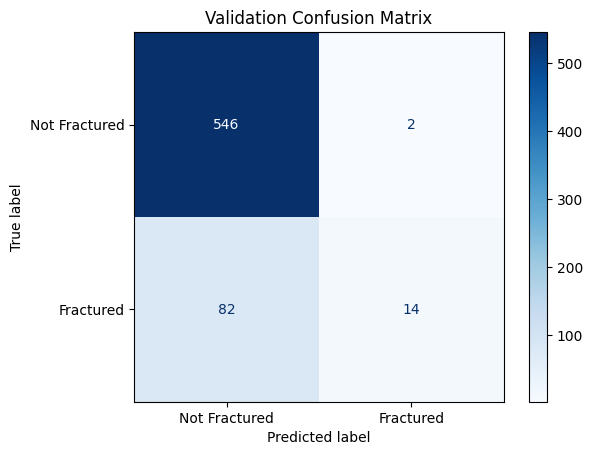

Test Accuracy: 0.8248
Test Precision: 0.7308
Test Recall: 0.1242


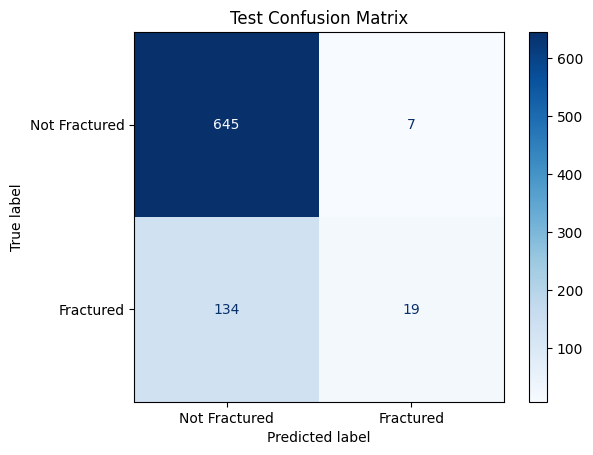

In [4]:
# Flat the features
features_train_flatten = features_train.reshape(features_train.shape[0], -1)
features_val_flatten = features_val.reshape(features_val.shape[0], -1)
features_test_flatten = features_test.reshape(features_test.shape[0], -1)

# Check shape
print(f"Flattened Train Features Shape: {features_train.shape}")
print(f"Flattened Validation Features Shape: {features_val.shape}")
print(f"Flattened Test Features Shape: {features_test.shape}")

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
random_forest_clf.fit(features_train_flatten, y_train)

# Predict on validation set
y_val_pred = random_forest_clf.predict(features_val_flatten)

# Calculate metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print metrics for validation set
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")



disp = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=["Not Fractured", "Fractured"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

# Predict on test set
y_test_pred = random_forest_clf.predict(features_test_flatten)

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics for test set
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=["Not Fractured", "Fractured"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()


Flattened Train Features Shape: (2575, 7, 7, 512)
Flattened Validation Features Shape: (644, 7, 7, 512)
Flattened Test Features Shape: (805, 7, 7, 512)
Validation Accuracy: 0.8711
Validation Precision: 0.9333
Validation Recall: 0.1458


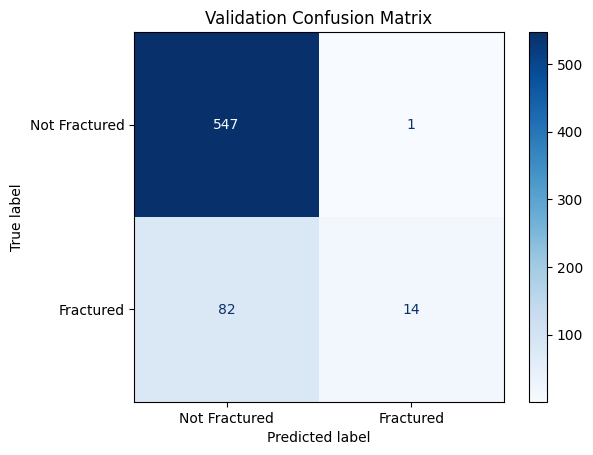

Test Accuracy: 0.8174
Test Precision: 0.6500
Test Recall: 0.0850


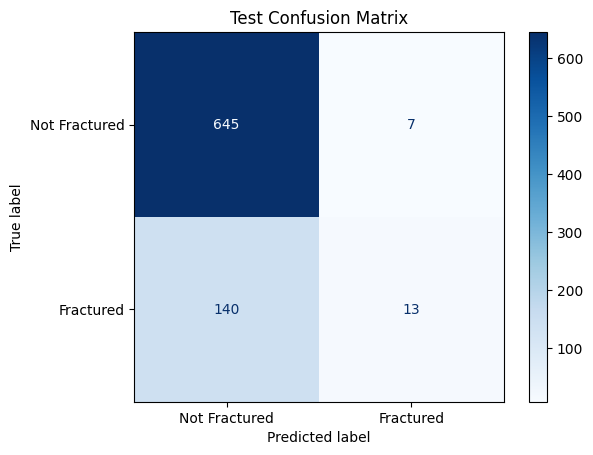

In [44]:
# Flat the features
features_train_flatten = features_train.reshape(features_train.shape[0], -1)
features_val_flatten = features_val.reshape(features_val.shape[0], -1)
features_test_flatten = features_test.reshape(features_test.shape[0], -1)

# Check shape
print(f"Flattened Train Features Shape: {features_train.shape}")
print(f"Flattened Validation Features Shape: {features_val.shape}")
print(f"Flattened Test Features Shape: {features_test.shape}")

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, criterion="entropy")

# Train the Random Forest classifier
random_forest_clf.fit(features_train_flatten, y_train)

# Predict on validation set
y_val_pred = random_forest_clf.predict(features_val_flatten)

# Calculate metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print metrics for validation set
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")


disp = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=["Not Fractured", "Fractured"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

# Predict on test set
y_test_pred = random_forest_clf.predict(features_test_flatten)

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics for test set
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=["Not Fractured", "Fractured"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()


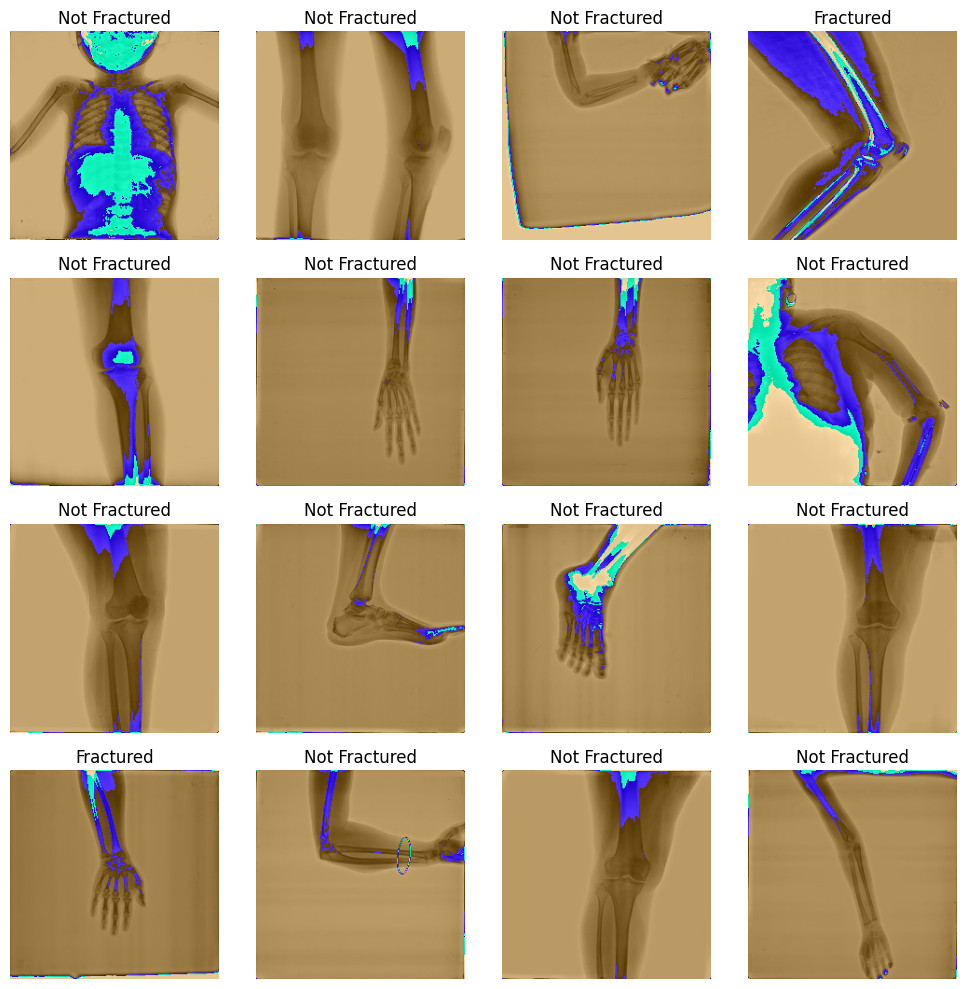

In [ ]:
def plot_images_gray(images, labels, rows=4, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        grayscale_image = images[i].squeeze() if len(images[i].shape) == 3 else images[i]  
        if grayscale_image.dtype != 'uint8':
            grayscale_image = (grayscale_image * 255).astype('uint8')
        ax.imshow(grayscale_image) 
        ax.set_title("Fractured" if labels[i] == 1 else "Not Fractured")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Print a plot with the first 16 images from the training set and their respective labels
plot_images_gray(X_test_orig[:16], y_train[:16])



In [53]:
def plot_images(images, true_labels, predictions=None, n_images=16):
    num_rows = (n_images + 3) // 4  
    plt.figure(figsize=(16, num_rows * 4))  
    for i in range(n_images):
        plt.subplot(num_rows, 4, i + 1)  
        image = images[i]
        # Check that image is type uint8 and in range [0, 255]
        if image.dtype != 'uint8':
            image = (image * 255).astype('uint8')
        plt.imshow(image)  
        title = f"True: {'Fractured' if true_labels[i] == 1 else 'Not Fractured'}"
        if predictions is not None:
            title += f", Pred: {'Fractured' if predictions[i] == 1 else 'Not Fractured'}"
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

KNN (k=3) Validation Metrics:
Accuracy: 0.8587, Precision: 0.5316, Recall: 0.4375
KNN (k=3) Test Metrics:
Accuracy: 0.8422, Precision: 0.6444, Recall: 0.3791


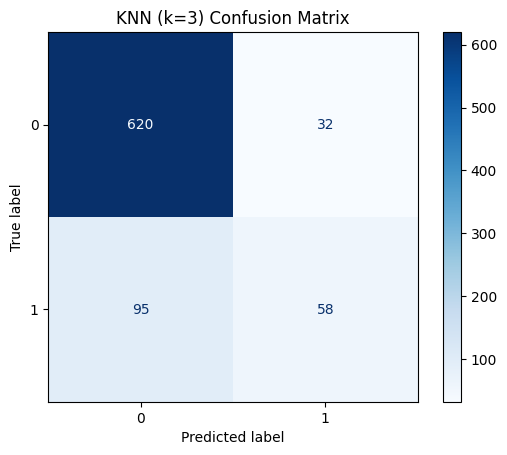

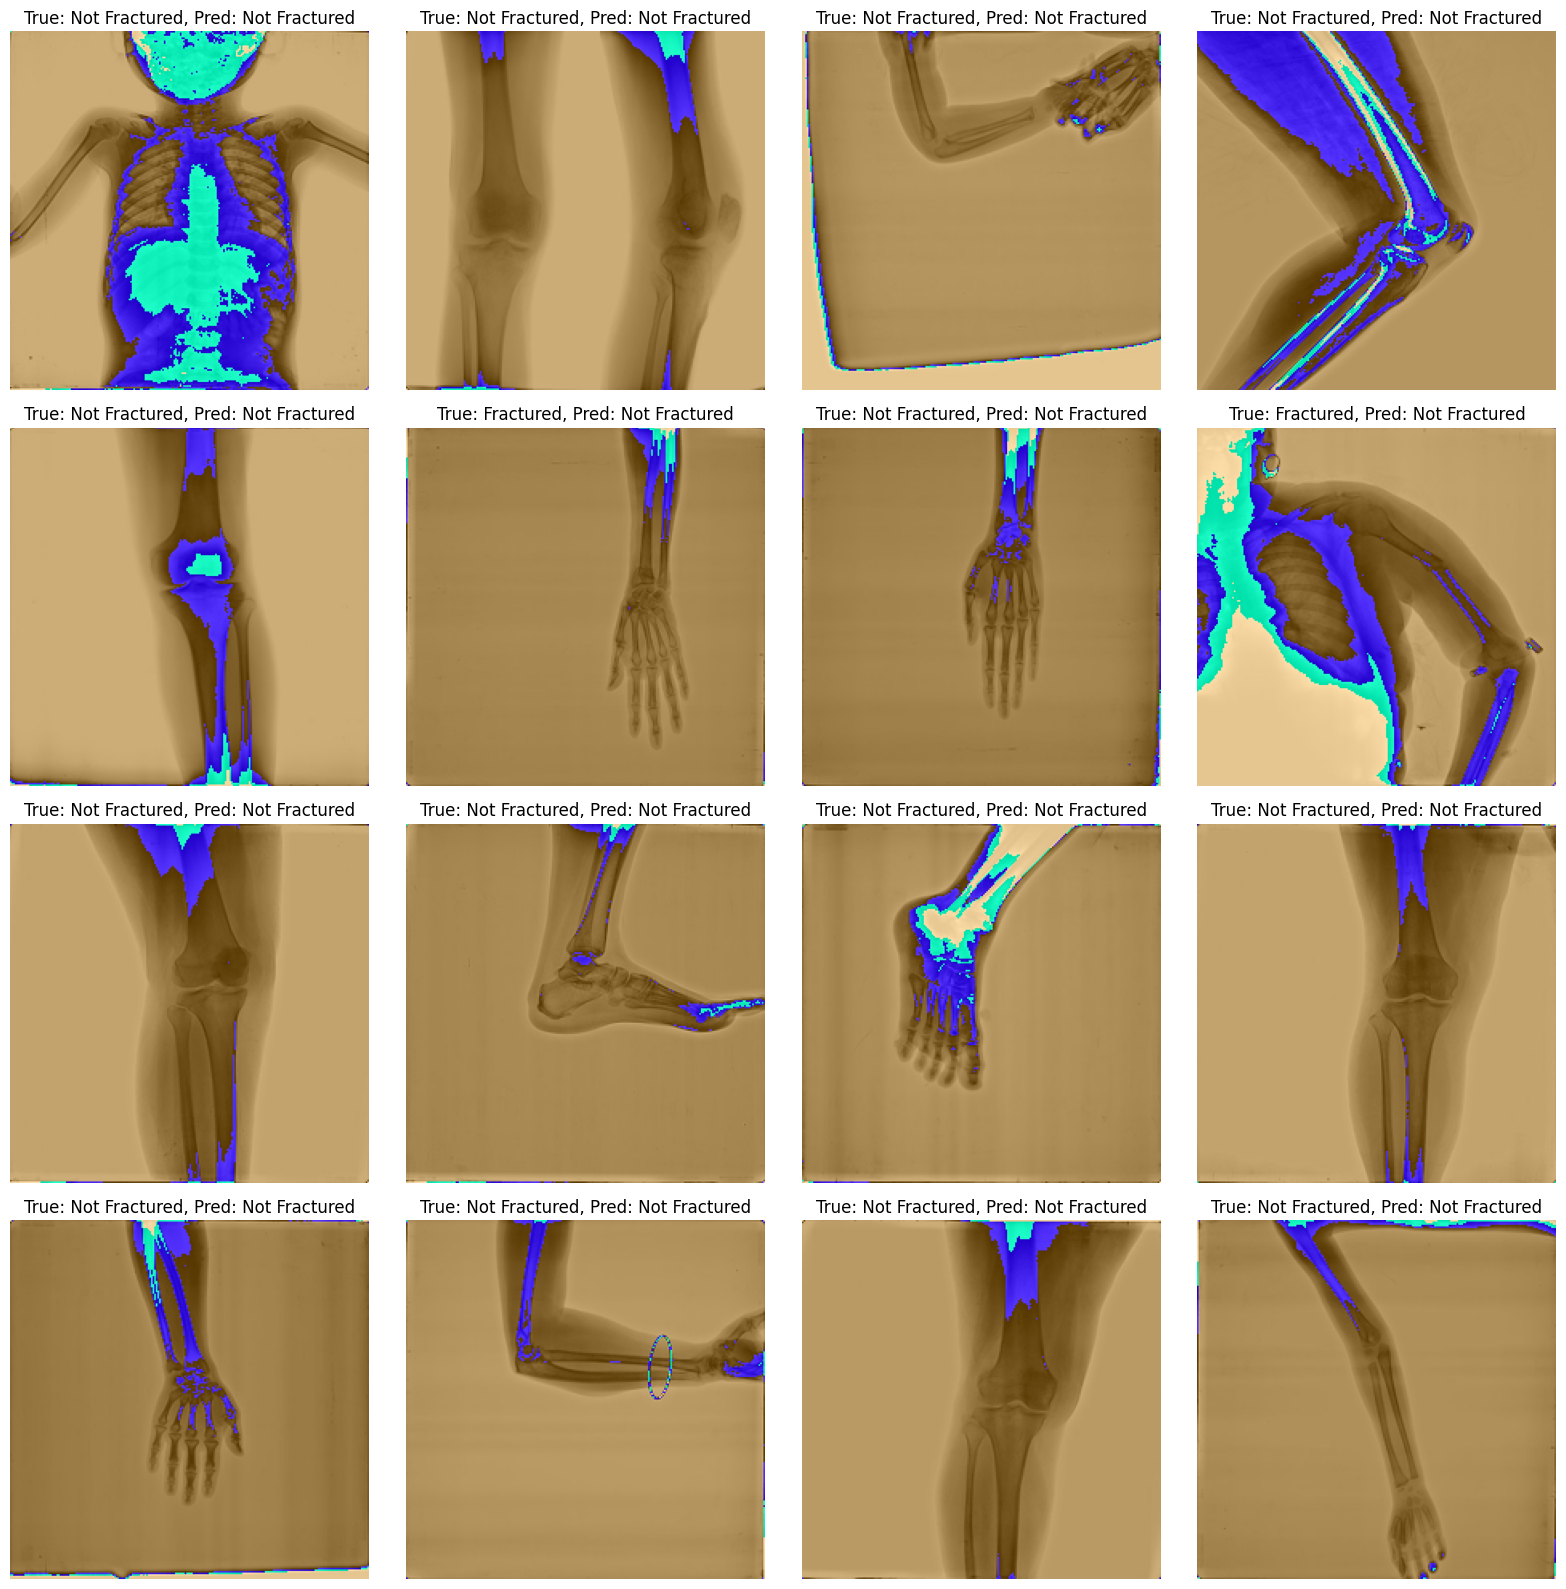

KNN (k=5) Validation Metrics:
Accuracy: 0.8820, Precision: 0.6471, Recall: 0.4583
KNN (k=5) Test Metrics:
Accuracy: 0.8311, Precision: 0.6000, Recall: 0.3333


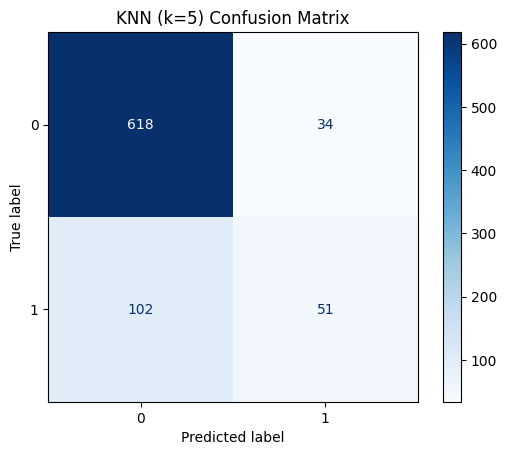

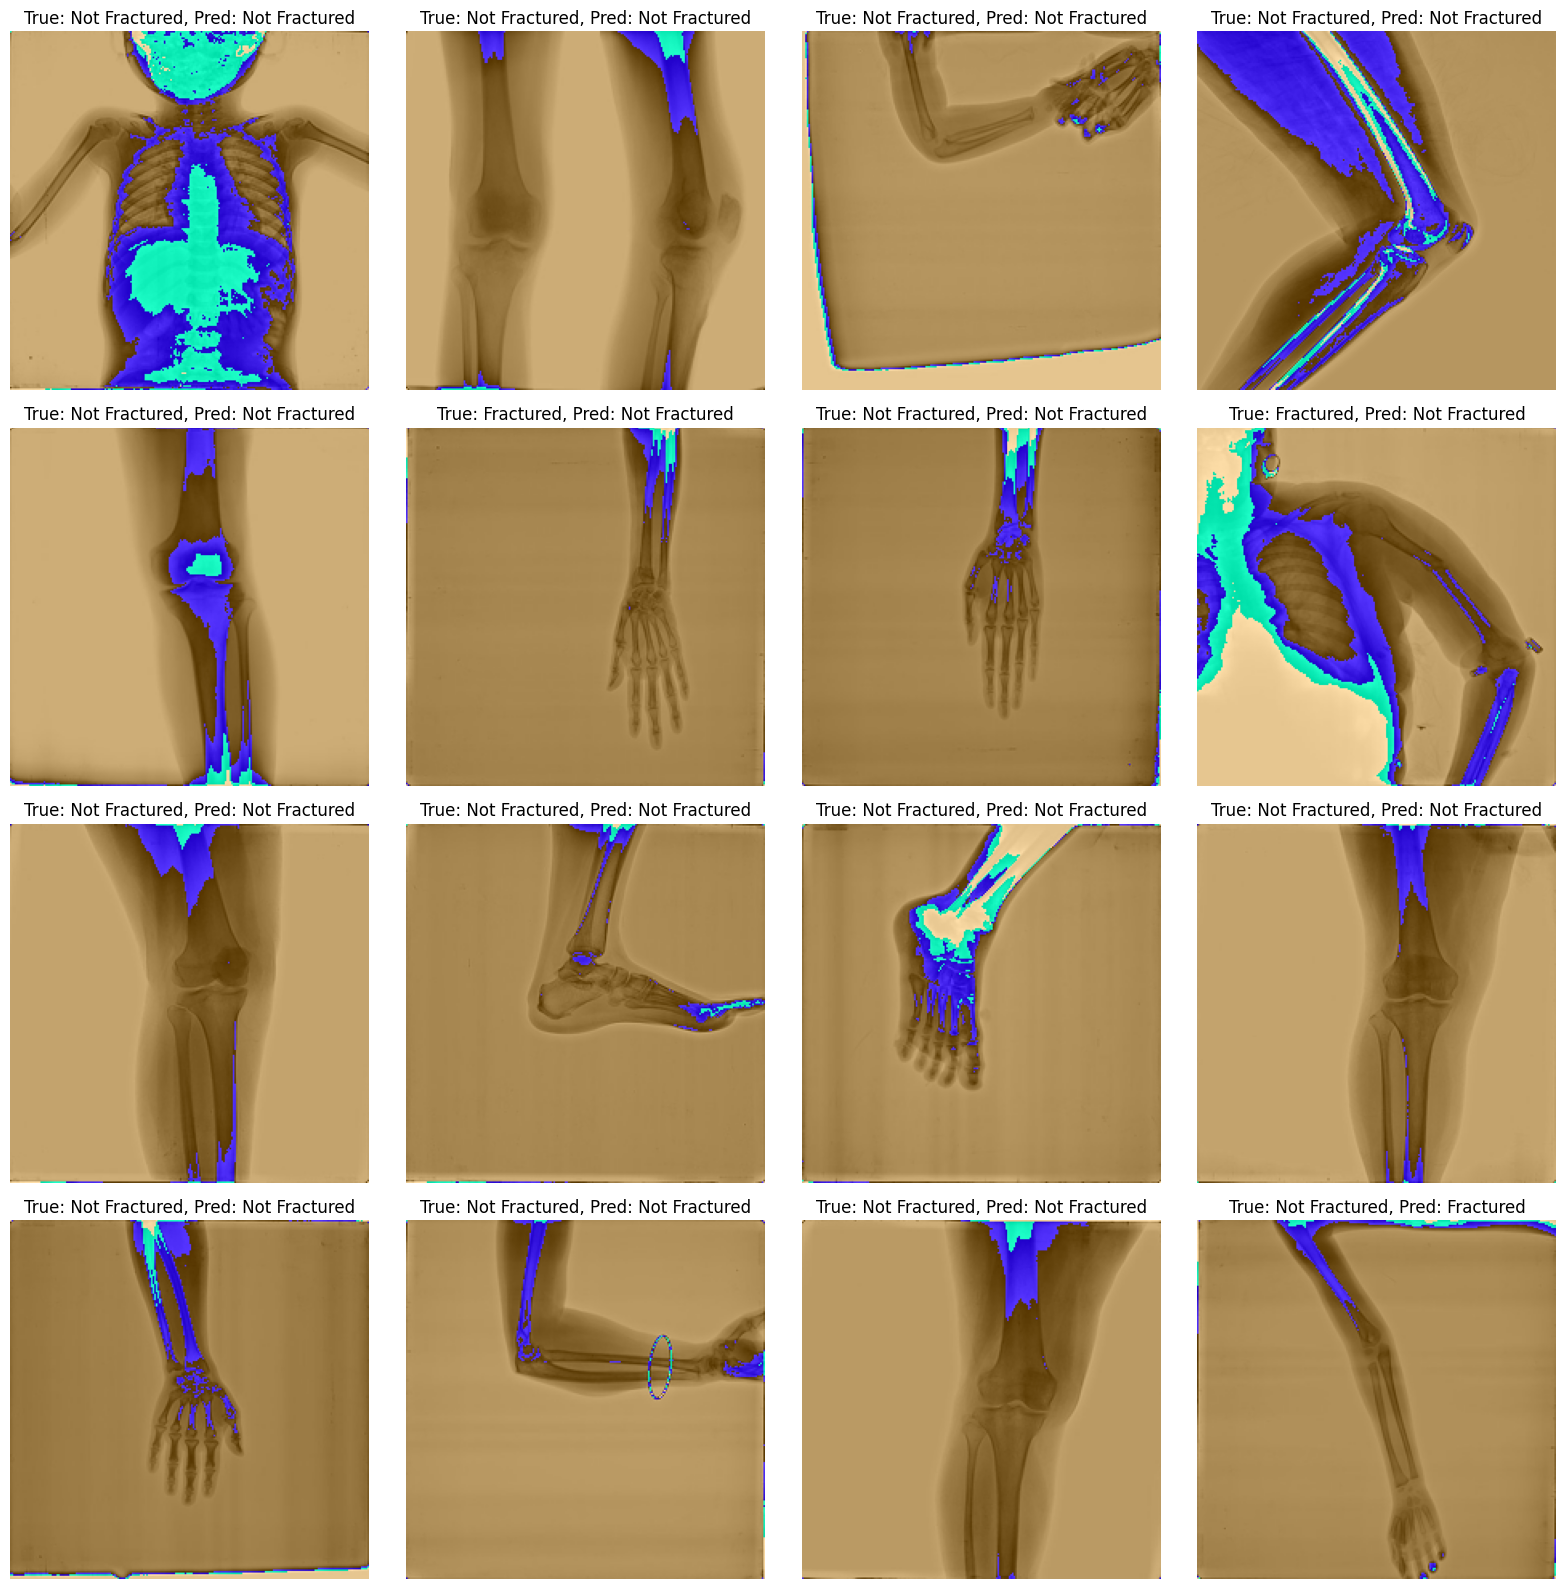

KNN (k=7) Validation Metrics:
Accuracy: 0.8680, Precision: 0.5902, Recall: 0.3750
KNN (k=7) Test Metrics:
Accuracy: 0.8373, Precision: 0.6528, Recall: 0.3072


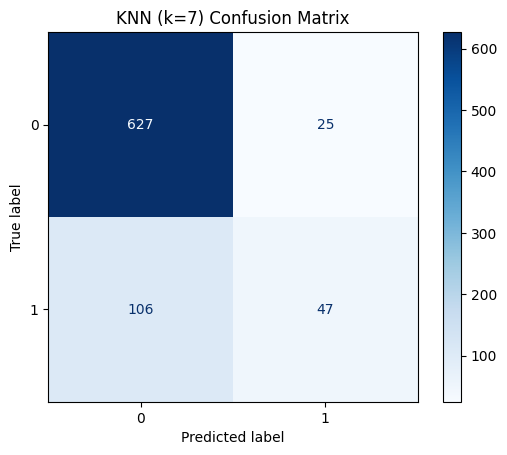

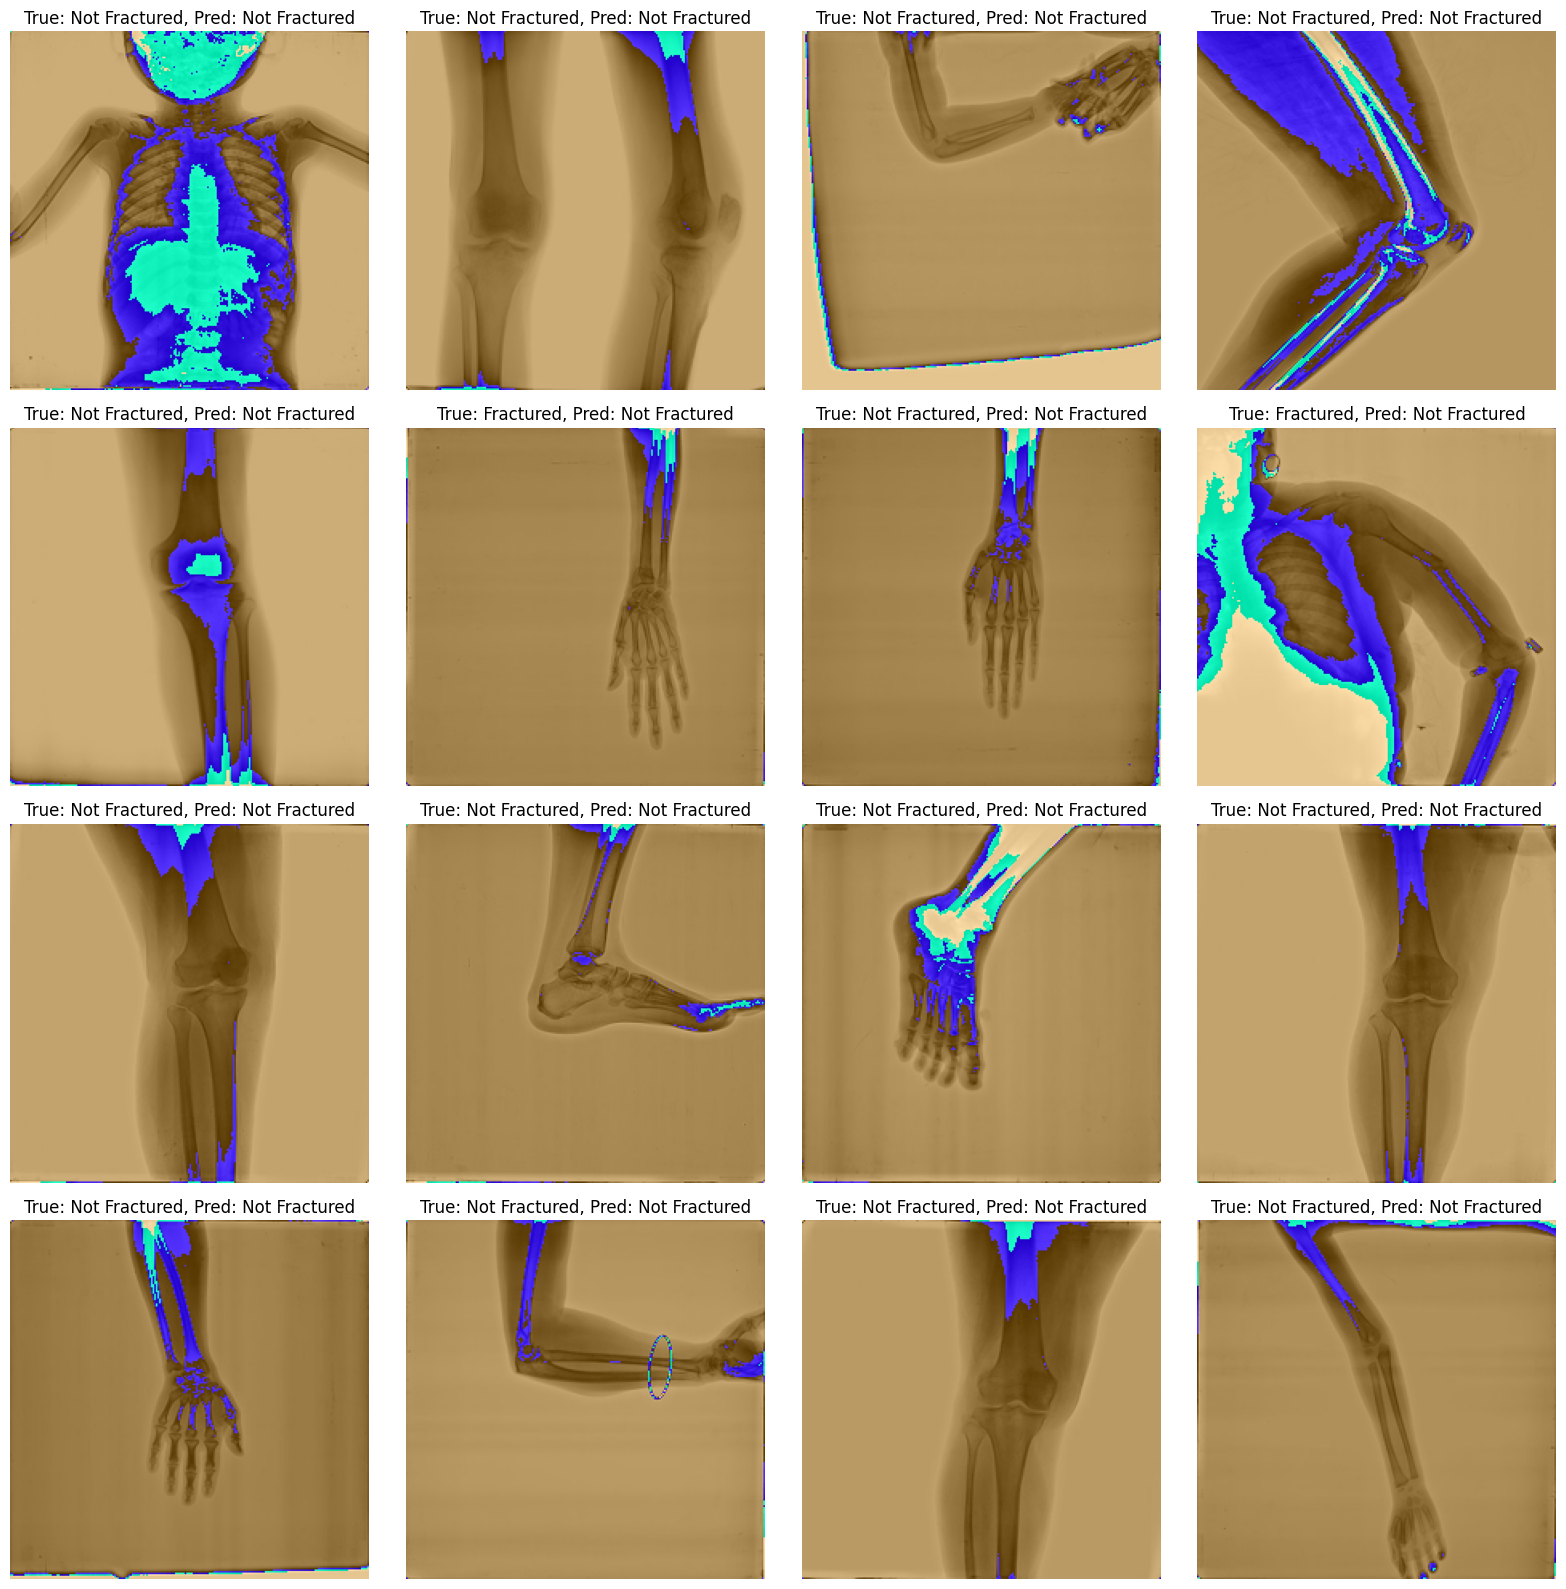

In [54]:
def knn_evaluate(k, X_train, y_train, X_val, y_val, X_test, y_test, x_origin):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train.reshape(len(X_train), -1), y_train)
    
    # Validation set evaluation
    y_val_pred = knn_classifier.predict(X_val.reshape(len(X_val), -1))
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    print(f"KNN (k={k}) Validation Metrics:")
    print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
    
    # Test set evaluation
    y_test_pred = knn_classifier.predict(X_test.reshape(len(X_test), -1))
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    print(f"KNN (k={k}) Test Metrics:")
    print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"KNN (k={k}) Confusion Matrix")
    plt.show()

    # Plot images
    plot_images(X_test_orig, y_test, predictions=y_test_pred)

# Evaluate KNN with different k values
knn_evaluate(3, features_train, y_train, features_val, y_val, features_test, y_test, X_test_orig)
knn_evaluate(5, features_train, y_train, features_val, y_val, features_test, y_test, X_test_orig)
knn_evaluate(7, features_train, y_train, features_val, y_val, features_test, y_test, X_test_orig)


SVM Validation Accuracy: 0.8960
SVM Validation Precision: 0.8993
SVM Validation Recall: 0.8960
SVM Test Accuracy: 0.8522
SVM Test Precision: 0.8446
SVM Test Recall: 0.8522


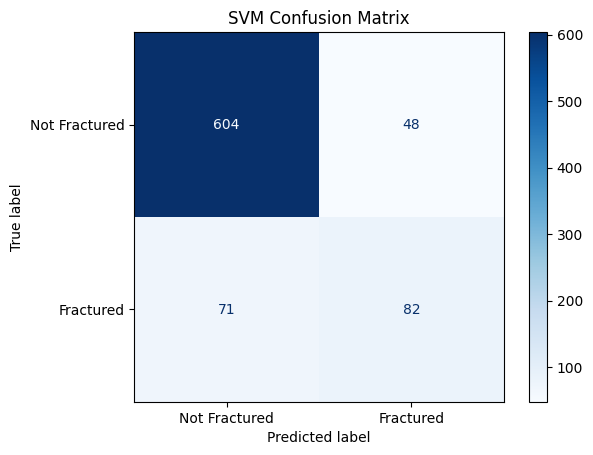

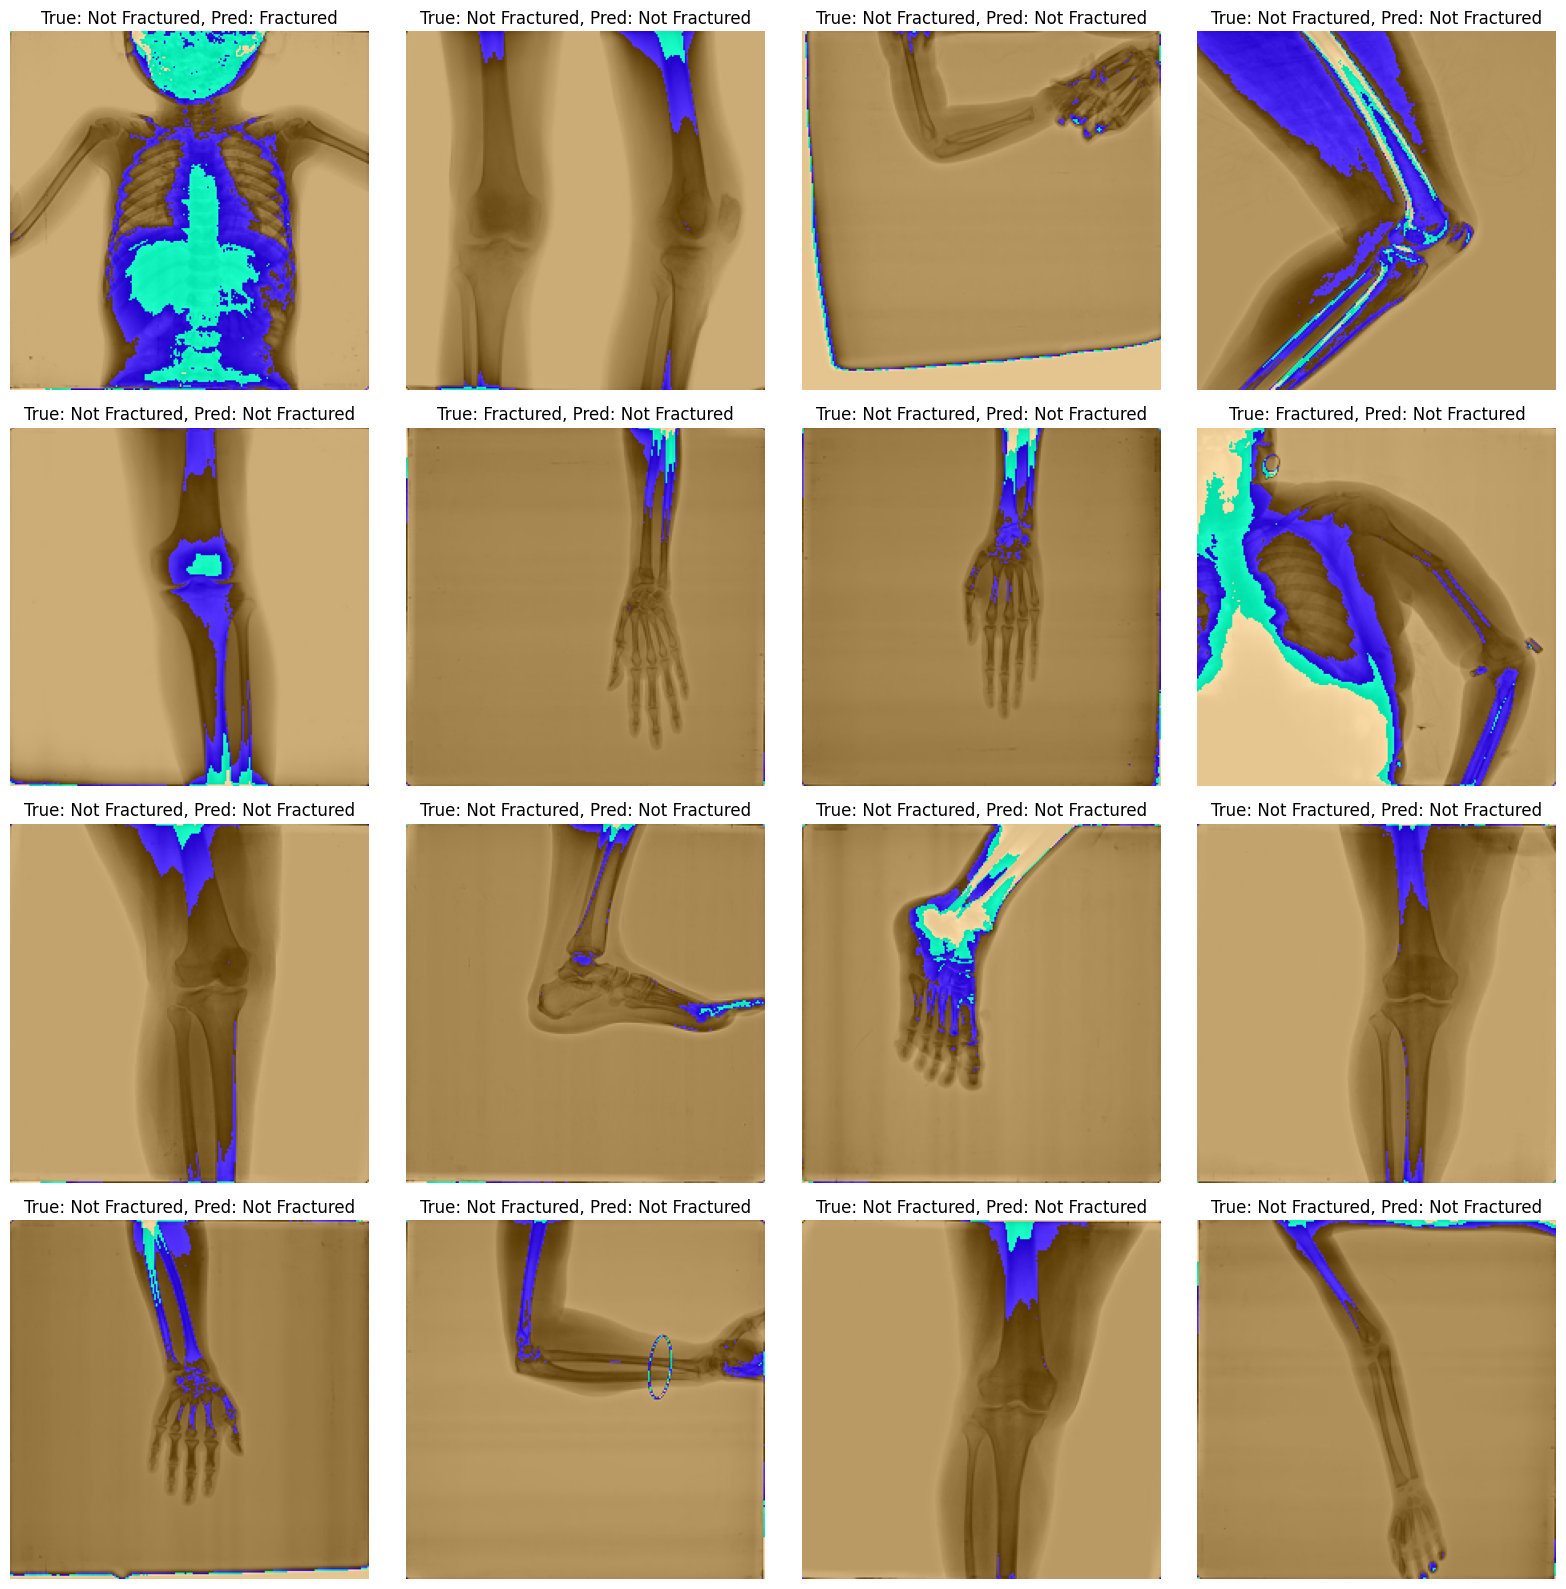

In [55]:
# Creating the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)   # Specify the kernel and the regularization parameter C

# Training the SVM classifier
svm_classifier.fit(features_train.reshape(len(features_train), -1), y_train)  # Fit the model to the training data

# Evaluating the model on validation data
y_val_pred = svm_classifier.predict(features_val.reshape(len(features_val), -1)) # Predict the validation labels
val_accuracy = accuracy_score(y_val, y_val_pred)   # Calculate the validation accuracy
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
print(f"SVM Validation Accuracy: {val_accuracy:.4f}")
print(f"SVM Validation Precision: {val_precision:.4f}")
print(f"SVM Validation Recall: {val_recall:.4f}")

# Evaluating the model on test data
y_test_pred = svm_classifier.predict(features_test.reshape(len(features_test), -1))  # Predict the test labels
test_accuracy = accuracy_score(y_test, y_test_pred)   # Calculate the test accuracy
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
print(f"SVM Test Accuracy: {test_accuracy:.4f}")
print(f"SVM Test Precision: {test_precision:.4f}")
print(f"SVM Test Recall: {test_recall:.4f}")


cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fractured", "Fractured"])
disp.plot(cmap=plt.cm.Blues)
plt.title("SVM Confusion Matrix")
plt.show()

plot_images(X_test_orig, y_test, predictions=y_test_pred)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7410 - loss: 3.4428 - val_accuracy: 0.8556 - val_loss: 0.4192
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8770 - loss: 0.2978 - val_accuracy: 0.8758 - val_loss: 0.3365
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9220 - loss: 0.2131 - val_accuracy: 0.8835 - val_loss: 0.3538
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9557 - loss: 0.1159 - val_accuracy: 0.8727 - val_loss: 0.4171
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9746 - loss: 0.0604 - val_accuracy: 0.8960 - val_loss: 0.3943
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9903 - loss: 0.0264 - val_accuracy: 0.8991 - val_loss: 0.4913
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9941 - loss: 0.0173 - val_accuracy: 0.9068 - val_loss: 0.4881
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9971 - loss: 0.0134 - val_accuracy: 0.9068 - va

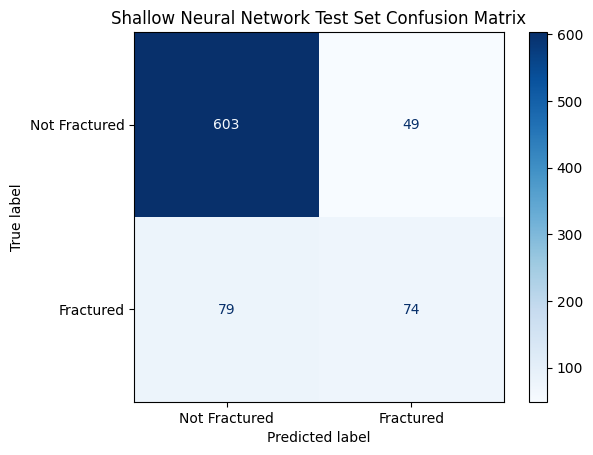

Shallow Neural Network Validation Set Metrics:
Accuracy: 0.8991
Precision: 0.6703
Recall: 0.6354


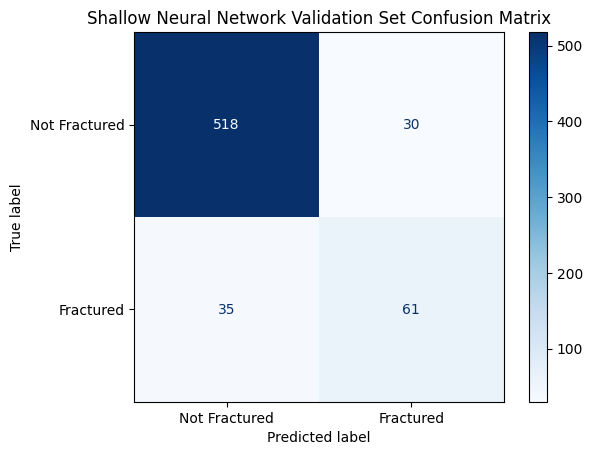

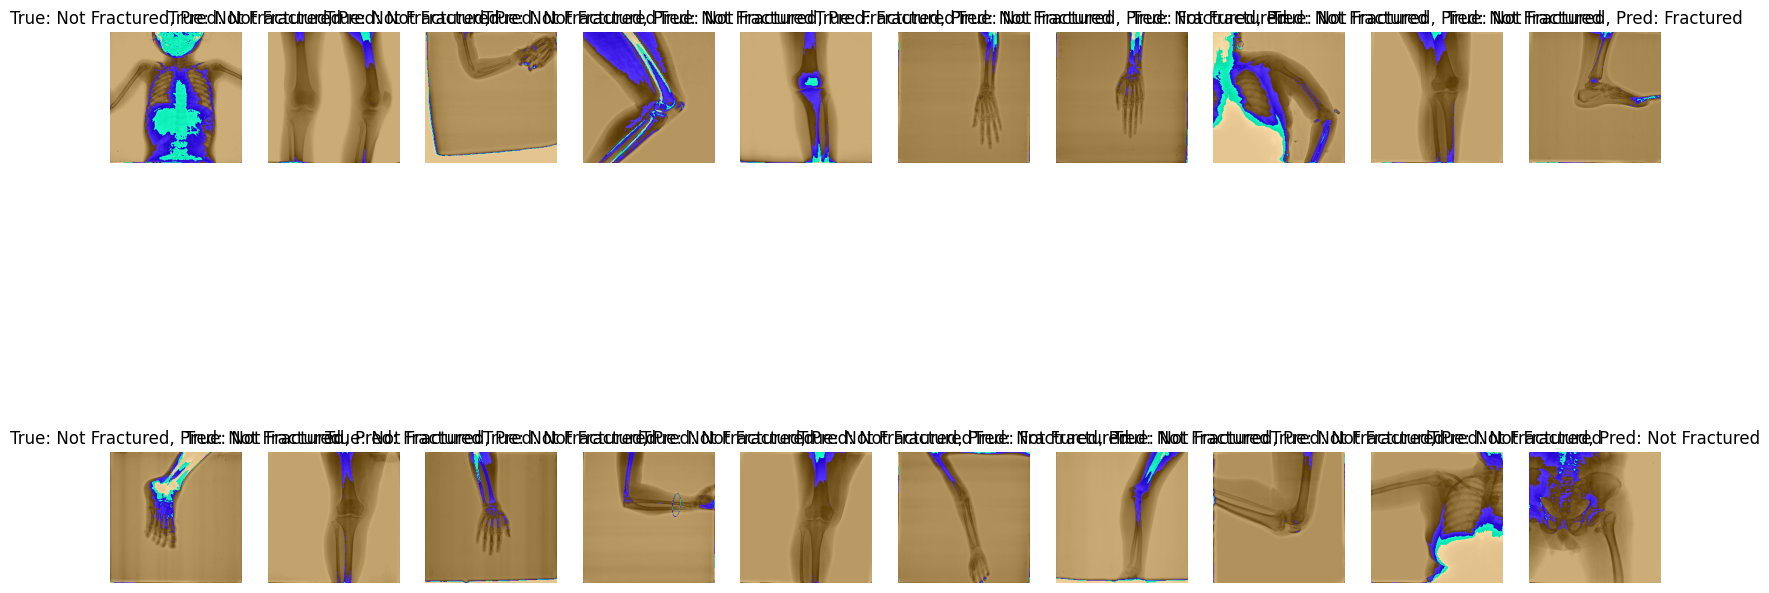

In [42]:
# Define the shallow neural network model
model_shallow = Sequential([
    Flatten(input_shape=(7, 7, 512)),  # Flatten to convert the image to a vector
    Dense(128, activation='relu'),  # Hidden layer with 128 neurons and ReLU activation
    Dense(1, activation='sigmoid')  # Output layer with 1 neuron and sigmoid activation for binary classification
])

# Compile the shallow neural network model
model_shallow.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the shallow neural network model
history_shallow = model_shallow.fit(features_train, y_train, epochs=10, batch_size=32, validation_data=(features_val, y_val))

# Evaluate the shallow neural network model on the test data
test_loss_shallow, test_accuracy_shallow = model_shallow.evaluate(features_test, y_test)
print(f"Shallow Neural Network Test Accuracy: {test_accuracy_shallow:.4f}")

# Evaluate on test set
y_pred_test = (model_shallow.predict(features_test) > 0.5).astype("int32")
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

# Evaluate on validation set
y_pred_val = (model_shallow.predict(features_val) > 0.5).astype("int32")
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
cm_val = confusion_matrix(y_val, y_pred_val)

# Print metrics for test set
print(f"Shallow Neural Network Test Set Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")

# Plot confusion matrix for test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Not Fractured", "Fractured"])
disp_test.plot(cmap=plt.cm.Blues)
plt.title(f"Shallow Neural Network Test Set Confusion Matrix")
plt.show()

# Print metrics for validation set
print(f"Shallow Neural Network Validation Set Metrics:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")

# Plot confusion matrix for validation set
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["Not Fractured", "Fractured"])
disp_val.plot(cmap=plt.cm.Blues)
plt.title(f"Shallow Neural Network Validation Set Confusion Matrix")
plt.show()

plot_images(X_test_orig, y_test, predictions=y_pred_val)

Shapes of input data - X_train_orig: (2575, 224, 224, 3), X_val_orig: (644, 224, 224, 3), X_test_orig: (805, 224, 224, 3)
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 293s 4s/step - accuracy: 0.0000e+00 - loss: 0.5840 - val_accuracy: 0.0000e+00 - val_loss: 0.2895
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 286s 4s/step - accuracy: 0.0000e+00 - loss: 0.2993 - val_accuracy: 0.0000e+00 - val_loss: 0.2939
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.0000e+00 - loss: 0.2759 - val_accuracy: 0.0000e+00 - val_loss: 0.3084
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 283s 4s/step - accuracy: 0.0000e+00 - loss: 0.2024 - val_accuracy: 0.0000e+00 - val_loss: 0.3515
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.0000e+00 - loss: 0.1899 - val_accuracy: 0.0000e+00 - val_loss: 0.2866
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 4.9361e-05 - loss: 0.1735 - val_accuracy: 0.0000e+00 - val_loss: 0.3209
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 292s 4s/step - accuracy: 2.712

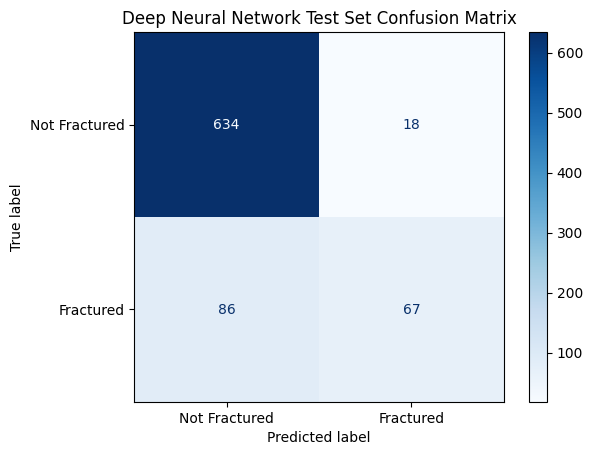

Test Accuracy: 0.8708
Test Precision: 0.7882
Test Recall: 0.4379
81/81 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step


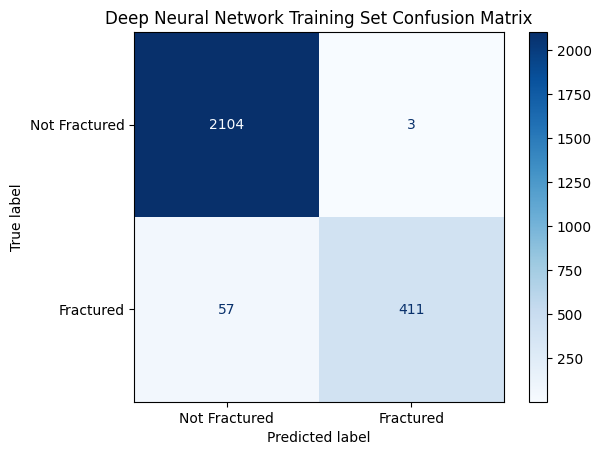

Training Accuracy: 0.9767
Training Precision: 0.9928
Training Recall: 0.8782
21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step


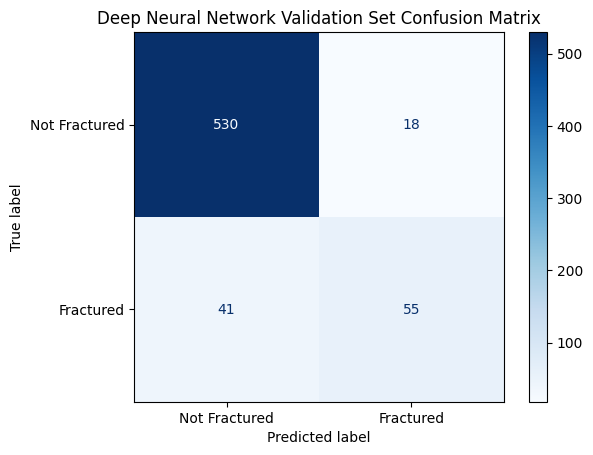

Validation Accuracy: 0.9084
Validation Precision: 0.7534
Validation Recall: 0.5729


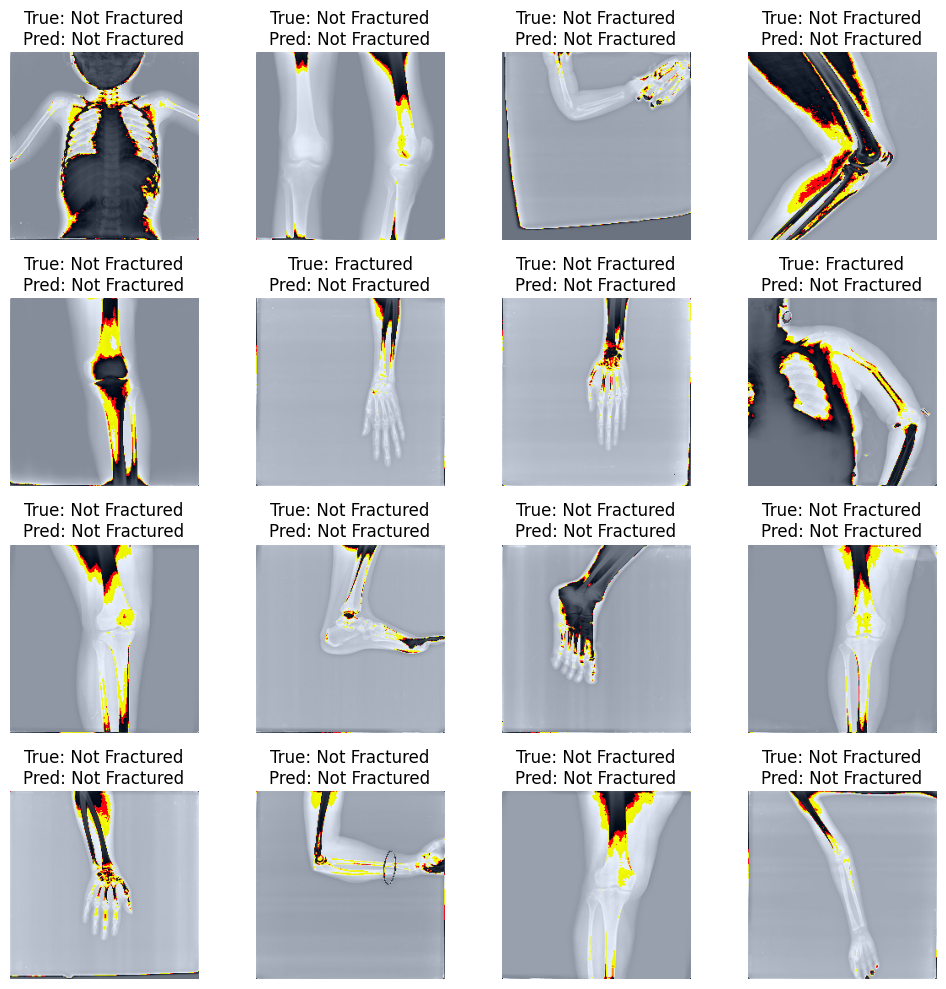

In [12]:

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model
base_model.trainable = False

# Add the custom classifier on top of the convolutional base
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Define the complete model for deep neural networks
model_deep = Model(inputs=base_model.input, outputs=output)

# Compile the deep neural network model
model_deep.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[Accuracy()])

# Ensure your data is in the correct shape
X_train_orig = np.array(X_train_orig)
X_val_orig = np.array(X_val_orig)
X_test_orig = np.array(X_test_orig)

print(f"Shapes of input data - X_train_orig: {X_train_orig.shape}, X_val_orig: {X_val_orig.shape}, X_test_orig: {X_test_orig.shape}")

# Train the deep neural network model
history_deep = model_deep.fit(X_train_orig, y_train, epochs=10, batch_size=32, validation_data=(X_val_orig, y_val))

# Evaluate the model on the test data
test_loss_deep, test_accuracy_deep = model_deep.evaluate(X_test_orig, y_test)
print(f"Deep Neural Network (VGG16) Test Accuracy: {test_accuracy_deep:.4f}")

# Ensure the test features are in the correct shape
features_test = np.array(X_test_orig)  # Assuming features_test is the same as X_test_orig
print(f"Shape of features_test: {features_test.shape}")

# Predictions on the test data
y_test_pred = (model_deep.predict(features_test) > 0.5).astype("int32")

# Compute metrics for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=["Not Fractured", "Fractured"])
disp_test.plot(cmap=plt.cm.Blues)
plt.title(f"Deep Neural Network Test Set Confusion Matrix")
plt.show()

print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")

# Predictions on the training data
y_train_pred = (model_deep.predict(X_train_orig) > 0.5).astype("int32")

# Compute metrics for the training set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)

disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=["Not Fractured", "Fractured"])
disp_train.plot(cmap=plt.cm.Blues)
plt.title(f"Deep Neural Network Training Set Confusion Matrix")
plt.show()

print(f"Training Accuracy: {accuracy_train:.4f}")
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")

# Predictions on the validation data
y_val_pred = (model_deep.predict(X_val_orig) > 0.5).astype("int32")

# Compute metrics for the validation set
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)

disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_val, display_labels=["Not Fractured", "Fractured"])
disp_val.plot(cmap=plt.cm.Blues)
plt.title(f"Deep Neural Network Validation Set Confusion Matrix")
plt.show()

print(f"Validation Accuracy: {accuracy_val:.4f}")
print(f"Validation Precision: {precision_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")

# Function to plot images with true and predicted labels
def plot_images(images, labels, preds, rows=4, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].astype(np.uint8))
        true_label = "Fractured" if labels[i] == 1 else "Not Fractured"
        pred_label = "Fractured" if preds[i] == 1 else "Not Fractured"
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize qualitative results
plot_images(X_test_orig[:16], y_test[:16], y_test_pred[:16])
